In [1]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]

In [2]:
filename = "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi/static-golgi-segmentations/all-raw-imgs/20210223_N02_001-alignV2-Scene-01-P1-C04.tif"
#filename = "//allen/aics/assay-dev/users/Benji/Sandwich_Block7_TF/patch_sampling_comparison/high_snr_patch_model/5500000635_EE_1-01_AcquisitionBlock7_pt7_Scene-23_aligned.ome.tiff"
#filename = "//allen/aics/microscopy/Antoine/transit/For Susanne/Golgi/Example 2/Raw data/Aligned only/5500000635_EE_1-01_AcquisitionBlock1_pt1_Scene-1_aligned.ome.tiff"

reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

#IMG = AICSImage(filename).reader.get_image_data('STCZYX').squeeze()


print(IMG.shape)
#print(IMG)

The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


(1, 2, 50, 1200, 1800)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


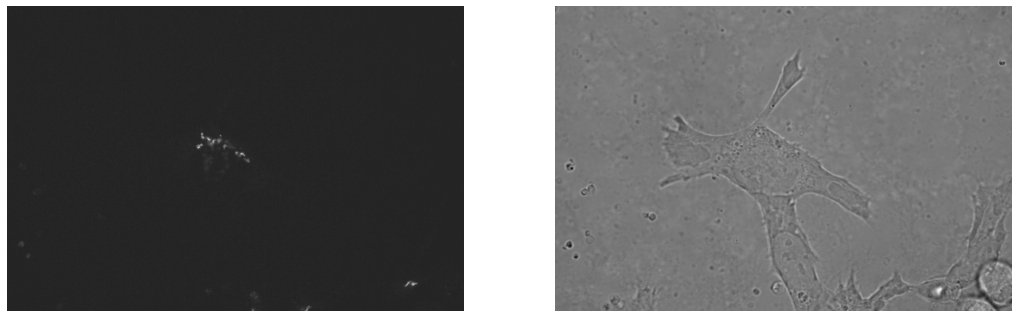

In [3]:
N_CHANNELS = IMG.shape[1] # 0 for L, 1 for all
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [7]:
#####################
structure_channel = 0
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [8]:
print(struct_img0.shape)

(50, 1200, 1800)


In [9]:
img_norm = intensity_normalization(struct_img0.copy(), scaling_param=[2, 20])# original: [2,20] #curremt: [2,20]
img_smooth = edge_preserving_smoothing_3d(img_norm, numberOfIterations=30)

In [10]:
th = 1.0* threshold_otsu(img_smooth) # original at 1.4 #current: 1.0
overall_shape = dilation(
    remove_small_objects(img_smooth > th, min_size=1, connectivity=1, in_place=False), #min_size = 10
    ball(1)
)
fixed_shape = erosion(
    hole_filling(overall_shape, hole_min=0, hole_max=5, fill_2d=True), #, hole_min= 0 hole_max = 5
    ball(1)
)

In [11]:
# 2d spot filter
s2 = np.zeros_like(fixed_shape)
for z in range(img_smooth.shape[0]):
    zslice = dot_2d(img_smooth[z,], 2)
    s2[z, :, :] = zslice > 0.02 #s2 0.03 # current: 0.02
fixed_shape = np.logical_or(s2, fixed_shape)

In [12]:
# 2d erosion for thinning
for z in range(fixed_shape.shape[0]):
    zslice= fixed_shape[z,]
    zslice = erosion(zslice, disk(1))
    fixed_shape[z, :, :] = zslice

response_vessel = vesselness3D(img_smooth, sigmas=[1], tau=1, whiteonblack=True)

seg = np.logical_or(response_vessel > 0.28, fixed_shape) # response_vessel > 0.28

seg = hole_filling(seg, hole_min=0, hole_max=15, fill_2d=True)# hole_min=0 # hole_max=15

In [13]:
imsave("OG-c04s1.tiff", seg)

In [ ]:
# Image paths with most common golgi structures
# "//allen/aics/assay-dev/users/Sandi/golgi-segmentations/all-raw-imgs/20210223_N02_001-alignV2-Scene-01-P1-C04.tif"
# "//allen/aics/assay-dev/users/Sandi/golgi-segmentations/all-raw-imgs/20210223_N02_001-alignV2-Scene-03-P3-C04.tif" *
# "//allen/aics/assay-dev/users/Sandi/golgi-segmentations/all-raw-imgs/20210312_N03_002-alignV2-Scene-03-P3-C02.tif" *
# "//allen/aics/assay-dev/users/Sandi/golgi-segmentations/all-raw-imgs/20210315_N01_002-alignV2-Scene-03-P3-C09.tif"

# add 2D size filter 
